### Figure 1 (A and B)
-----

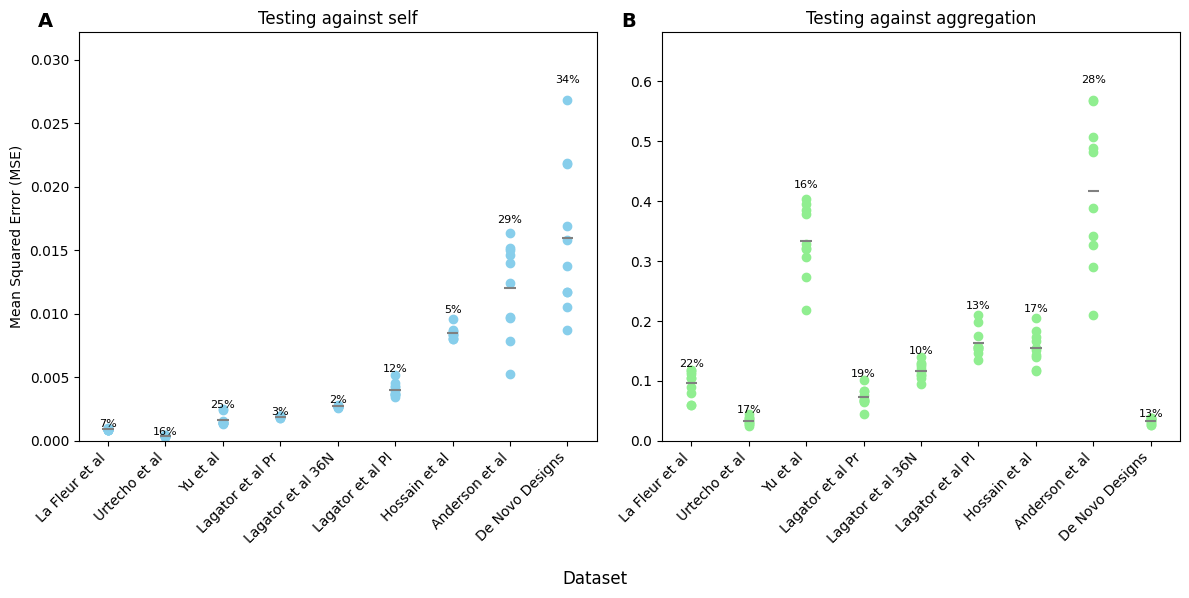

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Load Evaluation Metrics --------------------

def load_repeat_evaluate(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    results = {}
    for col in df.columns:
        if ' (Self)' in col:
            key = col.replace(' (Self)', '')
            results[key] = list(zip(df[f'{key} (Self)'], df[f'{key} (All)']))
    return results

# -------------------- Main Execution --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
all_results = load_repeat_evaluate('Data/repeat_evalute_each_file.csv')

file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]
x = np.arange(len(file_order))

# Calculate averages and coefficient of variation (CV)
avg_results = {f: np.mean(all_results[f], axis=0) for f in file_names}
avg_train = {f: res[0] for f, res in avg_results.items()}
avg_all = {f: res[1] for f, res in avg_results.items()}

cv_train = {f: np.std([r[0] for r in all_results[f]]) / avg_train[f] for f in file_names}
cv_all = {f: np.std([r[1] for r in all_results[f]]) / avg_all[f] for f in file_names}

# Extract MSEs
train_mse = {f: [r[0] for r in all_results[f]] for f in file_order}
all_mse = {f: [r[1] for r in all_results[f]] for f in file_order}
avg_train_list = [avg_train[f] for f in file_order]
avg_all_list = [avg_all[f] for f in file_order]

# -------------------- Plotting --------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, file in enumerate(file_order):
    ax1.scatter([x[i]] * len(train_mse[file]), train_mse[file], color='skyblue')
    ax1.hlines(avg_train_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax1.text(x[i], max(train_mse[file]) * 1.05, f'{int(cv_train[file]*100)}%', ha='center', fontsize=8)

ax1.set_xticks(x, file_order, rotation=45, ha='right')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Testing against self')
ax1.set_ylim(0, max(map(max, train_mse.values())) * 1.2)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

for i, file in enumerate(file_order):
    ax2.scatter([x[i]] * len(all_mse[file]), all_mse[file], color='lightgreen')
    ax2.hlines(avg_all_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax2.text(x[i], max(all_mse[file]) * 1.05, f'{int(cv_all[file]*100)}%', ha='center', fontsize=8)

ax2.set_xticks(x, file_order, rotation=45, ha='right')
ax2.set_title('Testing against aggregation')
ax2.set_ylim(0, max(map(max, all_mse.values())) * 1.2)

ax2.text(-0.05, 1.05, "B", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

fig.supxlabel("Dataset")
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Figures/Figure1.pdf', dpi=300, bbox_inches='tight')

### Figure 2
-----

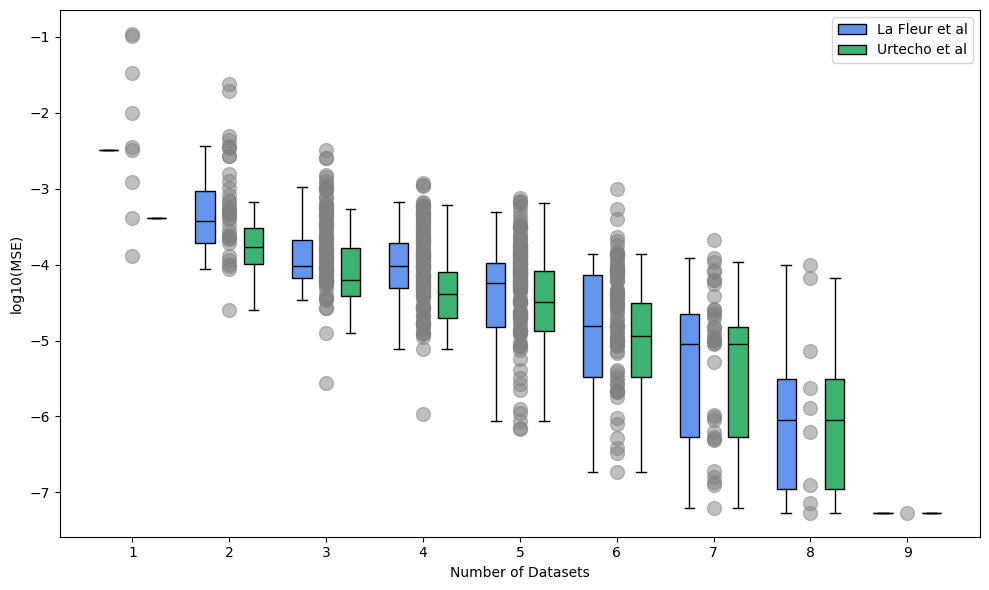

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load file names
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()
target_includes = ['La Fleur et al', 'Urtecho et al']
file_names = [f for f in file_names if f in target_includes]

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'La Fleur et al': 'cornflowerblue',
    'Urtecho et al': 'mediumseagreen'
}

x_all = sorted(set(int(n) for n, _, _ in data))

# Scatter plot
scatter_data = [(int(n), l) for n, l, _ in data]
x_vals, y_vals = zip(*scatter_data)
ax.scatter(x_vals, y_vals, s=100, alpha=0.5, color='grey')

# Boxplots
for x in x_all:
    for i, file_name in enumerate(target_includes):
        y_vals = [l for n, l, combo in data if int(n) == x and file_name in str(combo)]
        if not y_vals:
            continue

        # Offset x slightly for visual separation
        offset = -0.25 if i == 0 else 0.25
        ax.boxplot([y_vals], positions=[x + offset], widths=0.2, patch_artist=True,
                   boxprops=dict(facecolor=colors[file_name]), showfliers=False,
                   medianprops=dict(color='black'),
                   label=file_name if x == x_all[0] else None)

ax.set_xticks(x_all)
ax.set_xticklabels(x_all)

ax.set_xlabel('Number of Datasets')
ax.set_ylabel('log10(MSE)')
ax.legend()

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Figures/Figure2.pdf', dpi=300, bbox_inches='tight')


### Figure 3
-----

2025-04-11 16:19:26.436117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


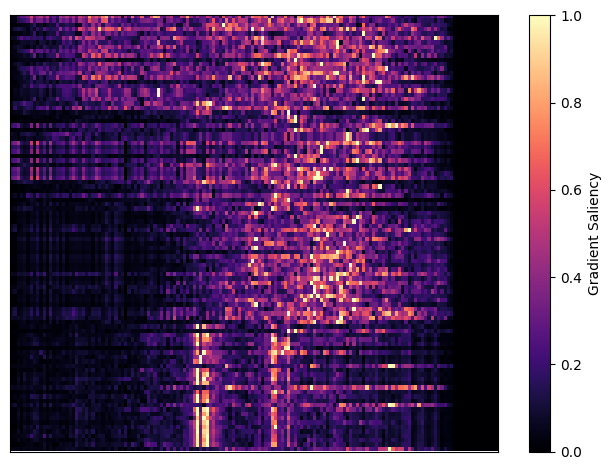

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])


# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

def plot_saliency_map_grid(
    model_filename,
    data,
    num_samples=100,
    random_state=42,
    sort_by_prediction=False,
    title=None,
    colorbar=False,
):
    model = load_model(model_filename)

    sequences = data.sample(n=min(num_samples, len(data)), random_state=random_state)['Promoter Sequence']
    sequences = preprocess_sequences(sequences)

    saliency_maps = []
    predictions = []

    for seq in sequences:
        pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
        saliency = np.abs(generate_saliency_map(model, seq))
        saliency = np.nan_to_num(saliency)
        predictions.append(pred)
        saliency_maps.append(saliency)

    if sort_by_prediction:
        saliency_maps = [saliency_maps[i] for i in np.argsort(predictions)]

    saliency_matrix = np.vstack(saliency_maps)

    im = plt.imshow(
        saliency_matrix, 
        cmap='magma', 
        aspect='auto', 
        vmin=saliency_matrix.min(), 
        vmax=saliency_matrix.max()
    )
    if colorbar:
        plt.colorbar(im, label='Gradient Saliency')
    plt.xticks([]); plt.yticks([])
    if title:
        plt.title(title)
    plt.tight_layout()

    # Save the figure
    plt.savefig('Figures/Figure3.pdf', dpi=300, bbox_inches='tight')

    plt.show()

data = pd.read_csv('Data/LaFleur_supp.csv')

plot_saliency_map_grid(
    model_filename='Models/CNN_6_1_2.keras',
    data=data,
    num_samples=100,
    random_state=1,
    sort_by_prediction=True,
    colorbar=True,
)

### Table 1
-----

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('Data/repeat_evalute_each_file.csv', index_col=0)

file_names = []
cv_self = []
cv_all = []

for i in range(0, len(df.columns), 2):
    col_self = df.columns[i]
    col_all = df.columns[i+1]
    file_name = col_self.replace(' (Self)', '')

    self_values = df[col_self]
    all_values = df[col_all]

    cv_s = self_values.std() / self_values.mean() if not self_values.empty else None
    cv_a = all_values.std() / all_values.mean() if not all_values.empty else None

    file_names.append(file_name)
    cv_self.append(cv_s)
    cv_all.append(cv_a)

cv_df = pd.DataFrame({
    "File Name": file_names,
    "Coefficient of Variation (Self)": cv_self,
    "Coefficient of Variation (All)": cv_all
})

# Merge with file name counts
file_name_counts = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].value_counts()
cv_df = cv_df.merge(file_name_counts.rename_axis('File Name').reset_index(), on='File Name')

# Rename, reorder columns
cv_df.rename(columns={'File Name' : 'Dataset', 'count': 'Dataset Size'}, inplace=True)
cv_df = cv_df[['Dataset', 'Dataset Size', 'Coefficient of Variation (Self)', 'Coefficient of Variation (All)']]

# Save the DataFrame to a CSV file
cv_df.to_csv('Figures/Table1.csv', index=False)

cv_df.head()

,Dataset,Dataset Size,Coefficient of Variation (Self),Coefficient of Variation (All)
0,La Fleur et al,5391,0.076679,0.239368
1,Urtecho et al,10898,0.173692,0.181598
2,Hossain et al,4350,0.056597,0.179277
3,Yu et al,1493,0.271977,0.177044
4,Lagator et al 36N,11485,0.028094,0.114040


### Table 2
-----

In [5]:
import pandas as pd
from scipy.stats import ttest_ind
from itertools import combinations, chain


def get_file_mse_effect(file_names, data_for_plot):
    all_combos = list(chain.from_iterable(combinations(file_names, i) for i in range(1, len(file_names) + 1)))
    file_mse = {tuple(sorted(combo)): None for combo in all_combos}
    
    for combo_str, mse in [(row[2], row[1]) for row in data_for_plot]:
        combo_key = tuple(sorted(combo_str.split(', ')))
        file_mse[combo_key] = mse

    mse_effect = {file: [] for file in file_names}
    
    for combo, value in file_mse.items():
        for file in file_names:
            if file in combo:
                continue
            extended_combo = tuple(sorted(combo + (file,)))
            mse_diff = value - file_mse.get(extended_combo, 0)
            mse_effect[file].append(mse_diff)
    
    return file_mse, mse_effect

def save_distribution_pvalues(file_names, data_for_plot, start_from, end_at):

    file_mse, _ = get_file_mse_effect(file_names, data_for_plot)

    p_value_results = {file_name: {} for file_name in file_names}
    mse_by_num_files = {i: [] for i in range(1, len(file_names) + 1)}

    for key, value in file_mse.items():
        mse_by_num_files[len(key)].append(value)

    end_at = end_at or len(file_names)

    for file_name in file_names:
        for i in range(start_from, end_at + 1):
            include_mse = [value for key, value in file_mse.items() if file_name in key and len(key) == i]
            exclude_mse = [value for key, value in file_mse.items() if file_name not in key and len(key) == i]

            # Perform t-test if both lists have more than one value
            if len(include_mse) > 1 and len(exclude_mse) > 1:
                _, p_value = ttest_ind(include_mse, exclude_mse, equal_var=False)
                p_value_results[file_name][f'P-Value {i} Files'] = p_value
            else:
                p_value_results[file_name][f'P-Value {i} Files'] = None

    # Convert the results to a DataFrame
    df = pd.DataFrame(p_value_results).T.reset_index()
    df.rename(columns={'index': 'File Name'}, inplace=True)
    df.sort_values('P-Value 3 Files', inplace=True)
    return df

# Main script
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()
data_for_plot = pd.read_csv('Data/data_comparison.csv').values
file_of_interest = 'Urtecho et al'
start_from, end_at = 3, 6

distribution_pvalues = save_distribution_pvalues(file_names, data_for_plot, start_from, end_at)

# Save the figure
distribution_pvalues.to_csv('Figures/Table2.csv', index=False)

distribution_pvalues.head(None)


,File Name,P-Value 3 Files,P-Value 4 Files,P-Value 5 Files,P-Value 6 Files
1,Urtecho et al,0.000001,2.088191e-12,1.095380e-11,1.594470e-15
7,Anderson et al,0.001522,4.636992e-04,1.056074e-03,1.799078e-02
2,Hossain et al,0.028052,9.466345e-03,4.270905e-01,6.640009e-01
0,La Fleur et al,0.053608,1.202489e-01,5.099382e-04,1.677996e-04
8,De Novo Designs,0.058745,2.694312e-02,5.897682e-04,1.201888e-02
3,Yu et al,0.170723,2.867923e-01,3.368017e-02,2.015414e-01
6,Lagator et al Pr,0.266976,2.560492e-01,8.846864e-01,6.402651e-01
4,Lagator et al 36N,0.305975,9.343862e-01,6.599167e-01,5.481340e-01
5,Lagator et al Pl,0.871367,9.580741e-01,8.762052e-01,5.221147e-02


# Supplementary Figures

### Figure S1 (A and B)
-----

In [6]:
df = pd.read_csv('Data/CNN_file_metrics.csv')
df.head()

,File Name,Training Data CV,All Data CV,Training Data MSE Averages,All Data MSE Averages,Sequence Count,Average Sequence Length,Sequence Lengths,Observed Expression,Average Observed Expression,Within-File Entropy,Average Pairwise Distance,Within-File Hamming Distance
0,La Fleur et al,0.072744,0.227085,0.000894,0.095725,5391,73.86496,"[74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 74, 7...","[-3.386326274, -3.392439032, -3.698902914, -3....",-2.638173,0.732649,61.819662,25.173317
1,Urtecho et al,0.164779,0.172279,0.000367,0.033381,10898,150.00000,"[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[-1.046079556, -1.431813084, -1.098599732, -1....",-1.903470,1.513936,96.575047,86.719749
2,Yu et al,0.258020,0.167959,0.001616,0.332792,1493,150.00000,"[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[-2.416324554, -1.69328491, -1.428471584, -4.2...",-2.598650,0.352242,71.581423,21.625176
3,Lagator et al Pr,0.039902,0.196077,0.001881,0.072140,12194,139.00000,"[139, 139, 139, 139, 139, 139, 139, 139, 139, ...","[-6.133261487, -6.08031203, -5.798335905, -5.1...",-5.421390,0.375852,64.010426,16.272864
4,Lagator et al 36N,0.026652,0.108187,0.002698,0.117030,11485,116.00000,"[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[-6.023111372, -6.067880909, -3.65581588, -6.2...",-4.131152,0.614703,67.810115,26.777638


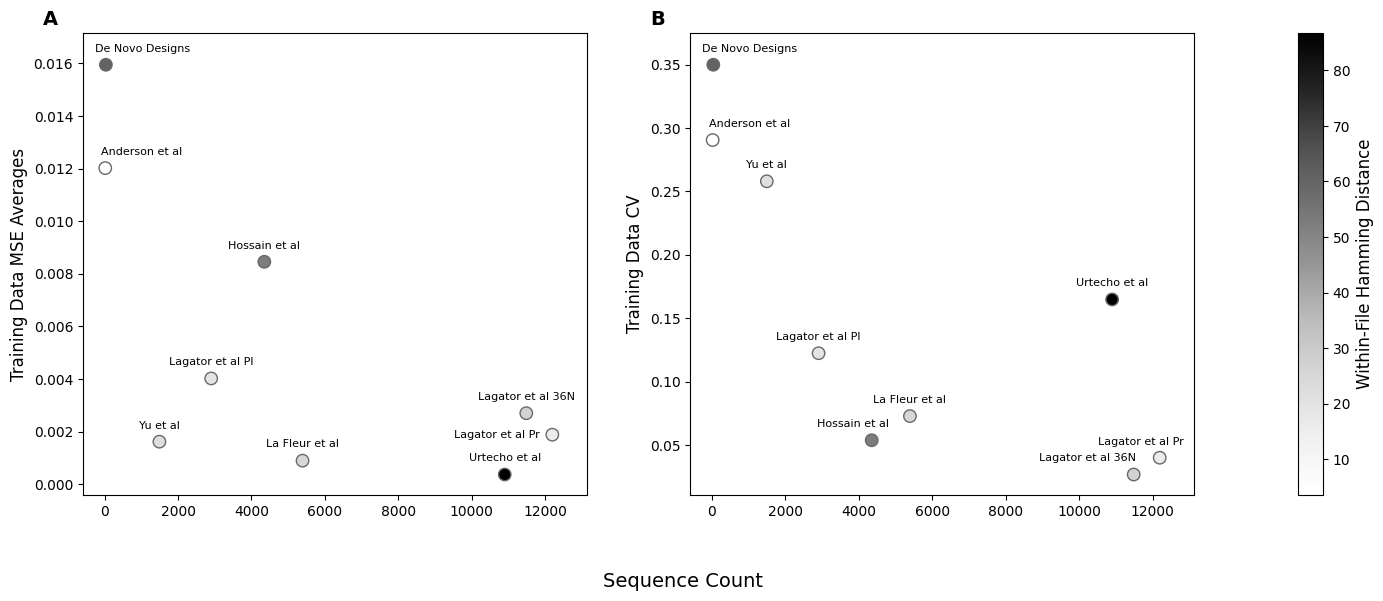

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm, colors as mcolors

def adjust_text_pos(idx, x, y, y_offset, label):
    custom_offsets = {
        ('De Novo Designs', None): (1000, 0),
        ('Anderson et al', None): (1000, 0),
        ('Lagator et al Pr', 0): (-1500, -y_offset * 1.5),
        ('Lagator et al Pr', 1): (-500, 0),
        ('Hossain et al', 1): (-500, 0),
        ('Lagator et al 36N', 1): (-1250, 0),
    }
    dx, dy = custom_offsets.get((label, idx)) or custom_offsets.get((label, None), (0, 0))
    return x + dx, y + dy

# Load data
df = pd.read_csv('Data/CNN_file_metrics.csv')

# Setup figure and axes
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
axes = [fig.add_subplot(gs[0, i]) for i in range(2)]

# Setup colormap normalization
color_col = 'Within-File Hamming Distance'
norm = mcolors.Normalize(vmin=df[color_col].min(), vmax=df[color_col].max())
cmap = cm.Greys

x_col = 'Sequence Count'
y_cols = ['Training Data MSE Averages', 'Training Data CV']

# Plot scatter plots
for idx, (ax, y_col) in enumerate(zip(axes, y_cols)):
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=df[color_col],
        cmap=cmap,
        edgecolor='dimgrey',
        s=80
    )

    # Adjust text annotations
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.025

    for _, row in df.iterrows():
        x, y = row[x_col], row[y_col] + y_offset
        label = row['File Name']
        adj_x, adj_y = adjust_text_pos(idx, x, y, y_offset, label)
        ax.text(adj_x, adj_y, label, fontsize=8, ha='center', va='bottom')

    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_offset)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + y_offset)
    ax.set_ylabel(y_col, fontsize=12)
    ax.text(-0.05, 1.05, chr(65 + idx), transform=ax.transAxes,
            ha='right', va='top', fontsize=14, fontweight='bold')

cbar_ax = fig.add_subplot(gs[0, 2])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax).set_label(color_col, fontsize=12)
fig.supxlabel(x_col, fontsize=14, y=-0.05)

# Show and save figure
plt.show()
fig.savefig('Figures/FigureS1.pdf', dpi=300, bbox_inches='tight')


### Table S1
-----

In [8]:
import pandas as pd

df = pd.read_csv('Data/CNN_file_metrics.csv')[['File Name', 'Within-File Entropy', 'Within-File Hamming Distance']]
df.to_csv('Figures/TableS1.csv', index=False)
df.head(None)

,File Name,Within-File Entropy,Within-File Hamming Distance
0,La Fleur et al,0.732649,25.173317
1,Urtecho et al,1.513936,86.719749
2,Yu et al,0.352242,21.625176
3,Lagator et al Pr,0.375852,16.272864
4,Lagator et al 36N,0.614703,26.777638
5,Lagator et al Pl,0.419147,19.612462
6,Hossain et al,1.799955,52.386382
7,Anderson et al,0.205827,3.580952
8,De Novo Designs,1.217053,60.679089


### Figure S2
-----

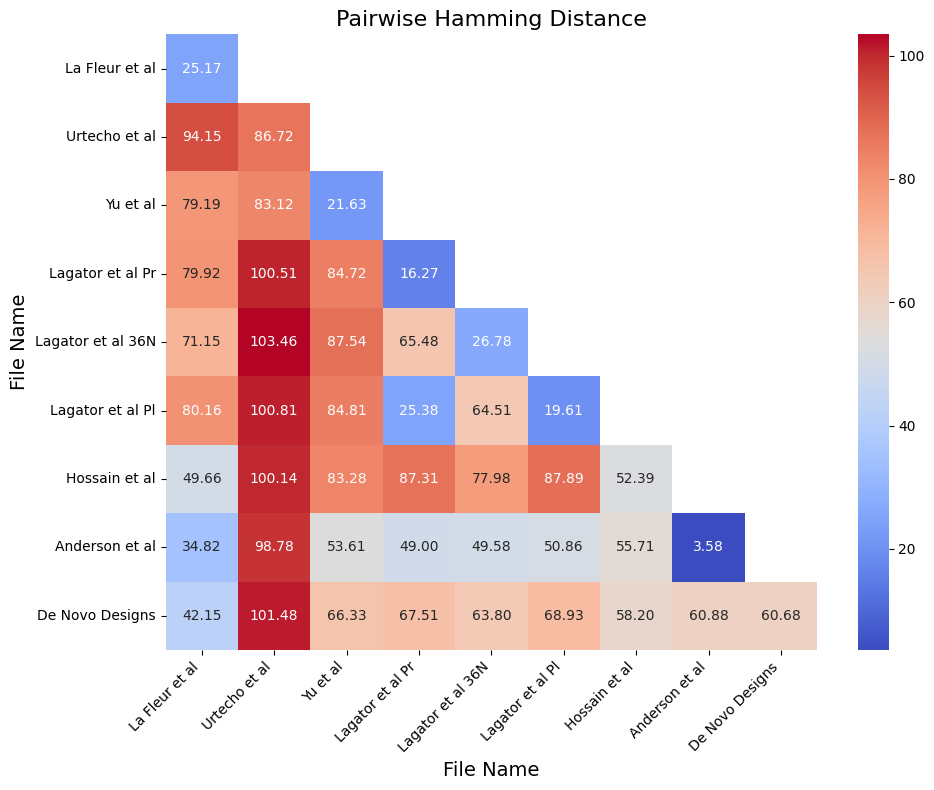

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairwise_distances = pd.read_csv('Data/pairwise_file_distance.csv', index_col=0)
mask = np.triu(np.ones(pairwise_distances.shape), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f", 
            mask=mask, 
            xticklabels=pairwise_distances.columns, 
            yticklabels=pairwise_distances.index)

plt.title('Pairwise Hamming Distance', fontsize=16)
plt.xlabel('File Name', fontsize=14)
plt.ylabel('File Name', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig('Figures/FigureS2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Figure S3
-----

3 Files: t-stat = -5.4735, p = 0.0000 (Significant)
4 Files: t-stat = -8.0197, p = 0.0000 (Significant)
5 Files: t-stat = -7.5630, p = 0.0000 (Significant)
6 Files: t-stat = -9.8354, p = 0.0000 (Significant)


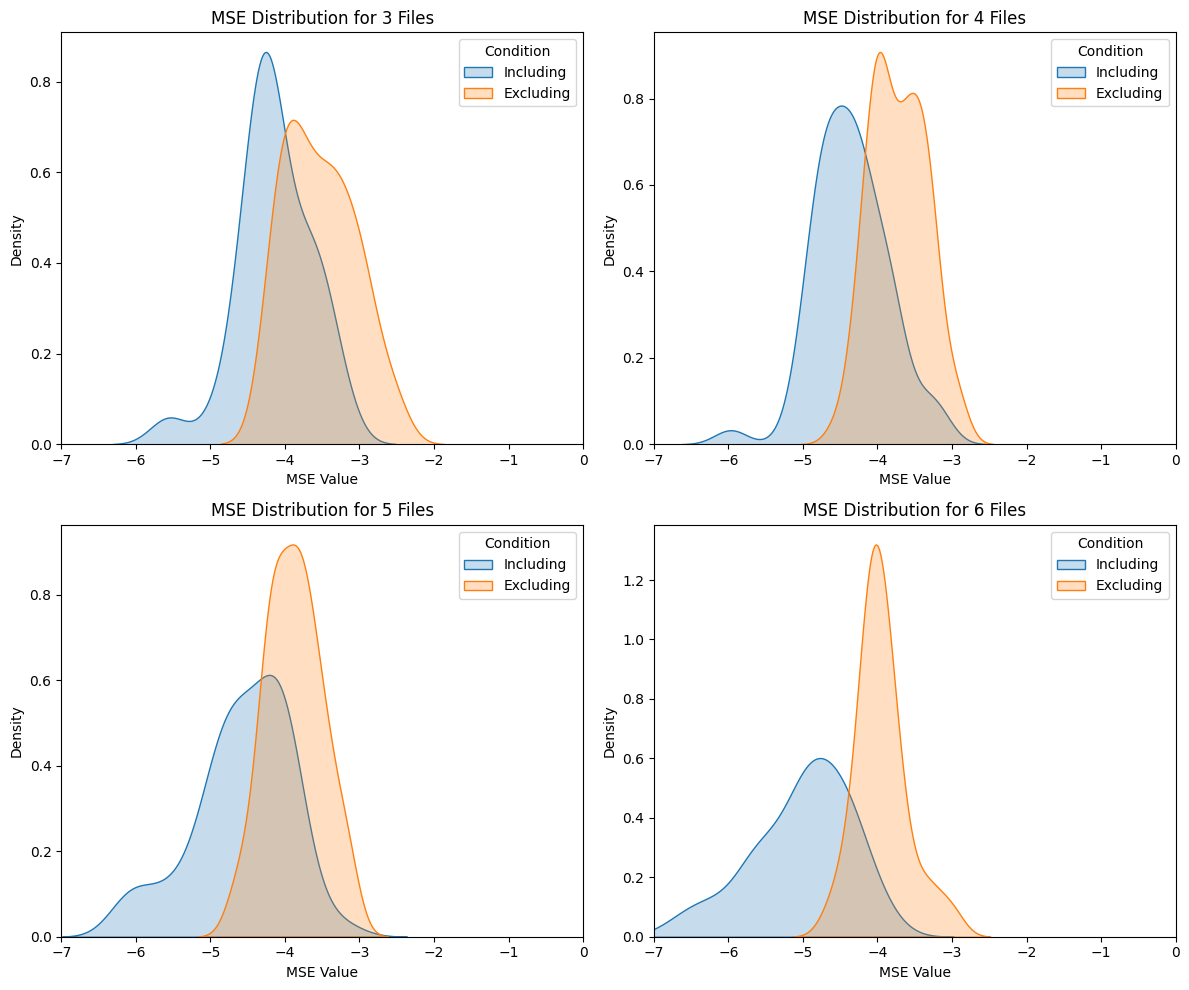

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
from itertools import combinations, chain

def get_file_mse_effect(file_names, data_for_plot):
    all_combos = list(chain.from_iterable(combinations(file_names, i) for i in range(1, len(file_names) + 1)))
    file_mse = {tuple(sorted(combo)): None for combo in all_combos}
    
    for combo_str, mse in [(row[2], row[1]) for row in data_for_plot]:
        combo_key = tuple(sorted(combo_str.split(', ')))
        file_mse[combo_key] = mse

    mse_effect = {file: [] for file in file_names}
    
    for combo, value in file_mse.items():
        for file in file_names:
            if file in combo:
                continue
            extended_combo = tuple(sorted(combo + (file,)))
            mse_diff = value - file_mse.get(extended_combo, 0)
            mse_effect[file].append(mse_diff)
    
    return file_mse, mse_effect

def group_mse_by_count(file_mse, file_of_interest, total_files):
    grouped = {True: {i: [] for i in range(1, total_files + 1)},
               False: {i: [] for i in range(1, total_files + 1)}}
    
    for combo, mse in file_mse.items():
        included = file_of_interest in combo
        grouped[included][len(combo)].append(mse)
    
    return grouped[True], grouped[False]

def plot_mse_distributions(include_mse, exclude_mse, start_from, end_at, file_of_interest):
    num_plots = end_at - start_from + 1
    n_cols = 2
    n_rows = (num_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.flatten()

    for idx, i in enumerate(range(start_from, end_at + 1)):
        inc, exc = include_mse[i], exclude_mse[i]

        if len(inc) > 1 and len(exc) > 1:
            t_stat, p_val = ttest_ind(inc, exc, equal_var=False)
            sig = " (Significant)" if p_val < 0.05 else ""
            print(f"{i} Files: t-stat = {t_stat:.4f}, p = {p_val:.4f}{sig}")
        else:
            print(f"{i} Files: Not enough data for t-test.")

        sns.kdeplot(inc, label='Including', fill=True, warn_singular=False, ax=axes[idx])
        sns.kdeplot(exc, label='Excluding', fill=True, warn_singular=False, ax=axes[idx])

        axes[idx].set_title(f'MSE Distribution for {i} Files')
        axes[idx].set_xlabel('MSE Value')
        axes[idx].set_ylabel('Density')
        axes[idx].set_xlim(-7, 0)
        axes[idx].legend(title='Condition')

    plt.tight_layout()
    plt.show()
    return fig

# Main script
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()
data_for_plot = pd.read_csv('Data/data_comparison.csv').values
file_of_interest = 'Urtecho et al'
start_from, end_at = 3, 6

file_mse, mse_effect = get_file_mse_effect(file_names, data_for_plot)
include_mse, exclude_mse = group_mse_by_count(file_mse, file_of_interest, len(file_names))
fig = plot_mse_distributions(include_mse, exclude_mse, start_from, end_at or len(file_names) - 1, file_of_interest)

# Save the figure
fig.savefig('Figures/FigureS3_option1.pdf', dpi=300, bbox_inches='tight')


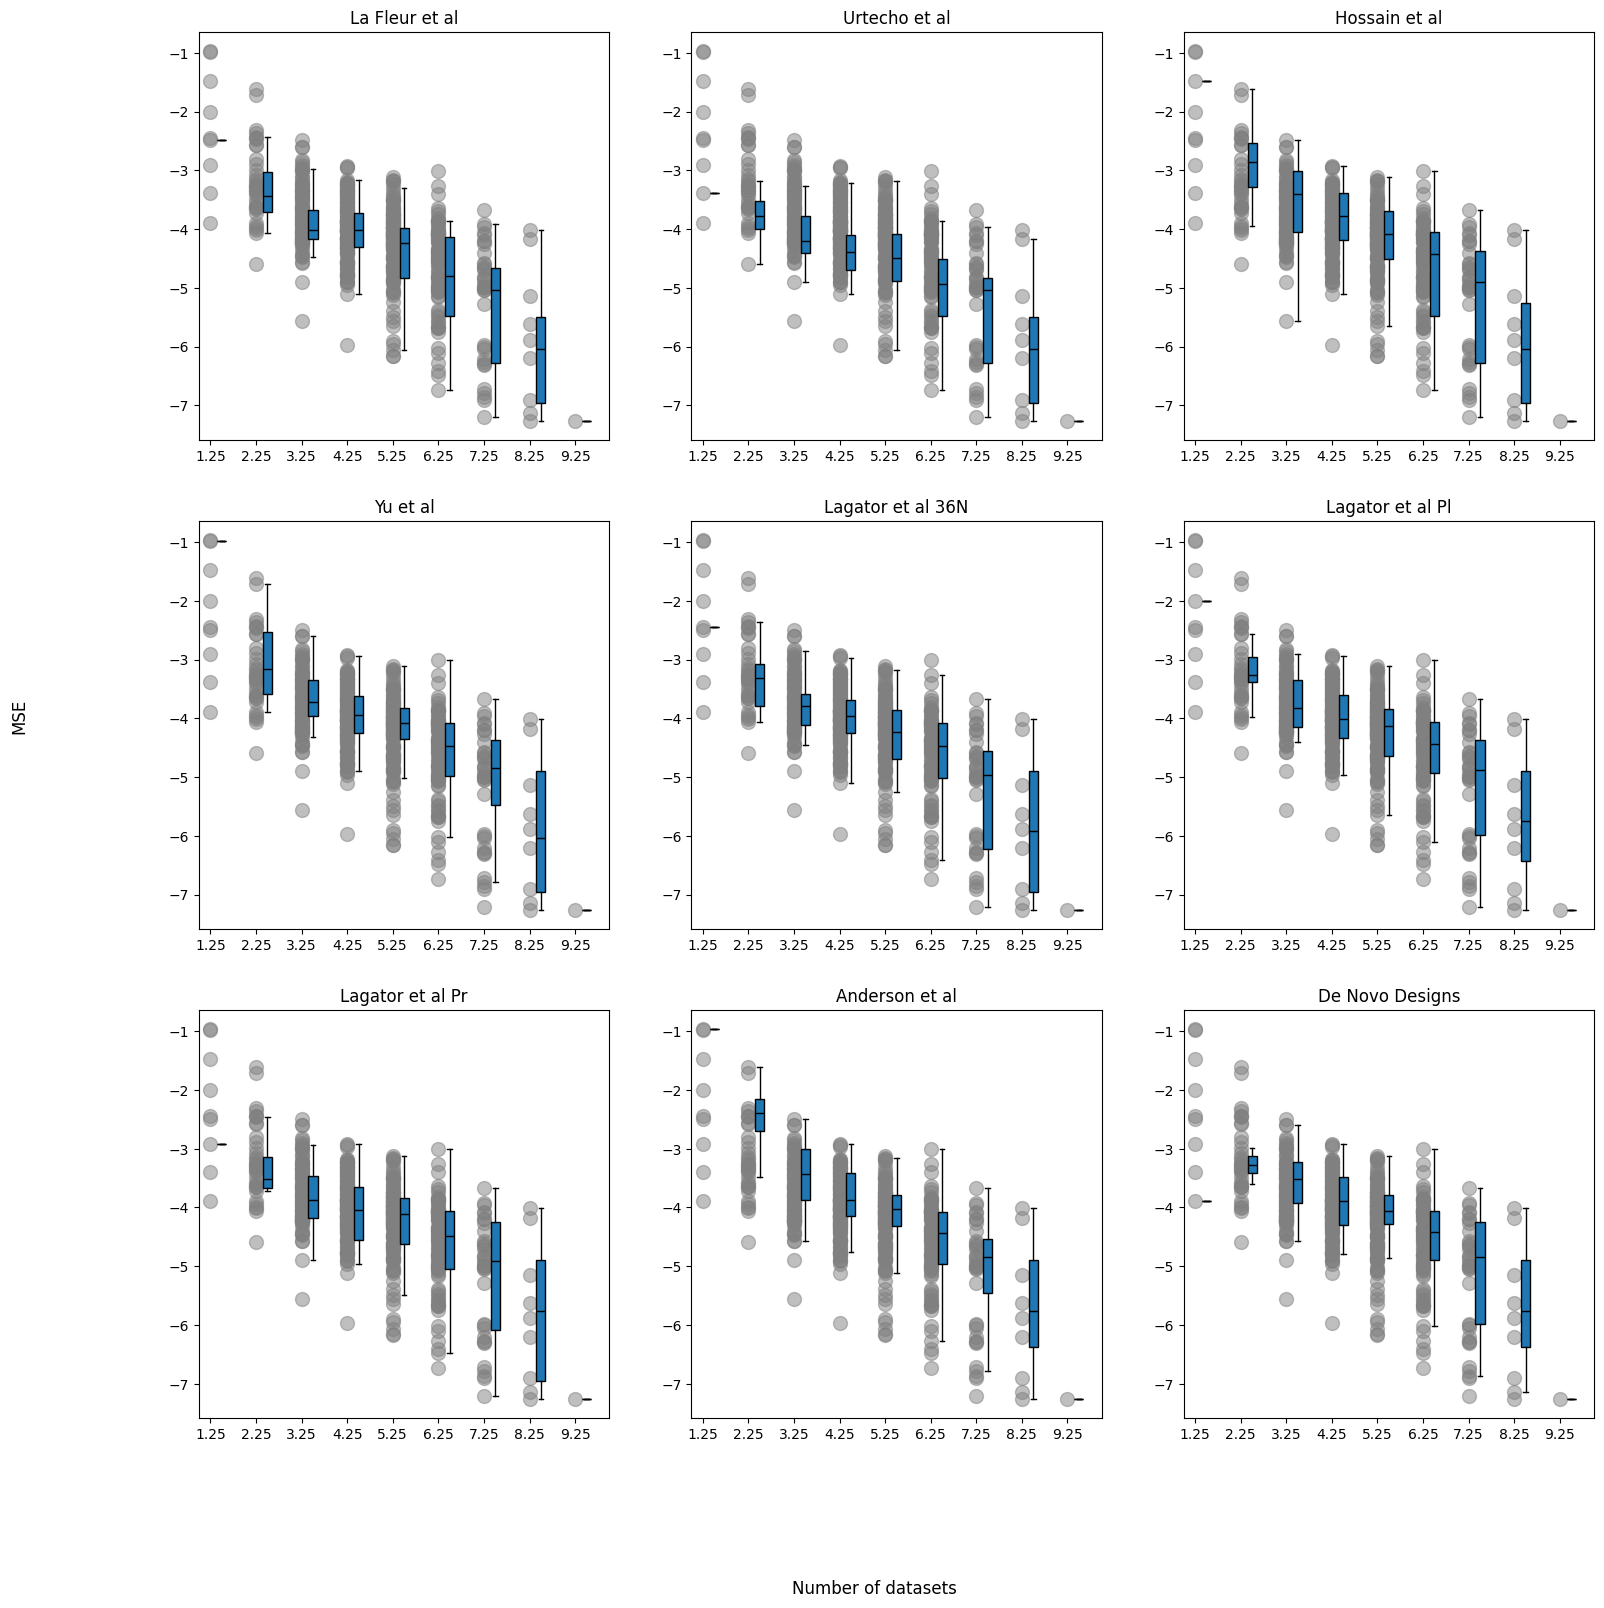

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

x_all = sorted(set(int(n) for n, _, _ in data))

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, file_name in enumerate(file_names):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    
    scatter_data = [(int(n), l) for n, l, _ in data]
    x_vals, y_vals = zip(*scatter_data)
    ax.scatter(x_vals, y_vals, s=100, alpha=0.5, color='grey')
    ax.set_title(file_name)
    for x in x_all:
        y_vals = [mse for n, mse, combo in data if int(n) == x and file_name in str(combo)]
        
        # Offset x slightly for visual separation
        offset = 0.25
        ax.boxplot([y_vals], positions=[x + offset], 
                   widths=0.2, patch_artist=True, showfliers=False,
                   medianprops=dict(color='black'))
    ax.set_xticks(x_all)
fig.supxlabel("Number of datasets")
fig.supylabel("MSE")

fig.savefig('Figures/FigureS3_option2.pdf', dpi=300, bbox_inches='tight')
